In [1]:
from rxitect.models.lightning.generator import Generator
import torch
from rxitect.structs.vocabulary import SelfiesVocabulary
import selfies as sf
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import seaborn as sns

In [2]:
selfies_lstm = torch.load("../models/pretrained_selfies_rnn.ckpt")

In [3]:
voc = SelfiesVocabulary("../data/processed/selfies_voc.txt")
prior = Generator(vocabulary=voc)
prior.load_state_dict(selfies_lstm['state_dict'])

<All keys matched successfully>

In [6]:
x = prior.sample(1_000)

In [8]:
decoded_samples = [sf.decoder(voc.decode(sample)) for sample in x]

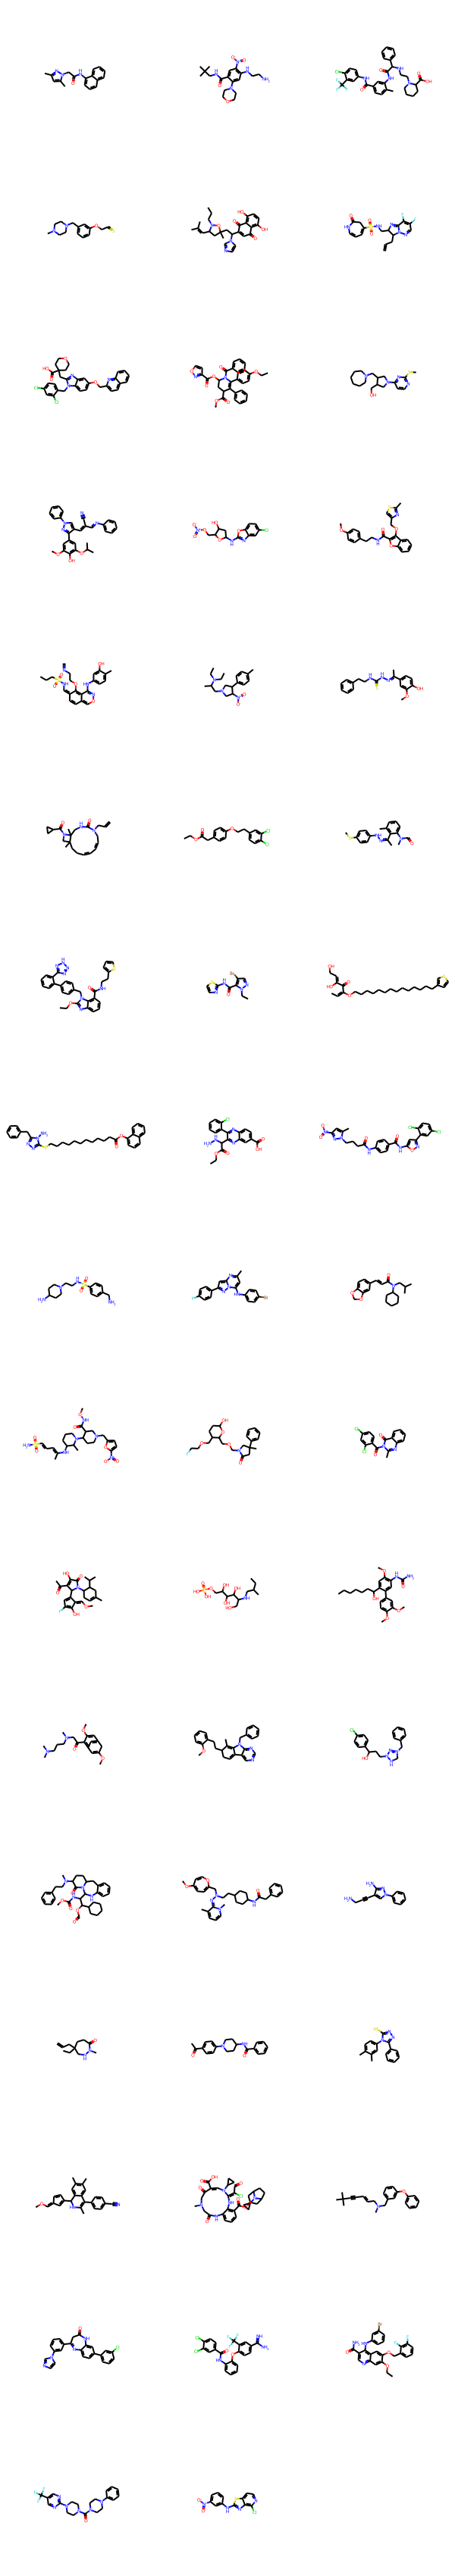

In [35]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in decoded_samples[:50]])

In [12]:
selfies_sample = [(voc.decode(sample)) for sample in x]

In [13]:
lengths = []
for smp in selfies_sample:
    lengths.append(len(list(sf.split_selfies(smp))))

In [17]:
print(f"standard dev.: {np.std(lengths)}")
print(f"max: {np.max(lengths)}")
print(f"min: {np.min(lengths)}")
print(f"median: {np.median(lengths)}")

standard dev.: 14.912913028647354
max: 109
min: 10
median: 44.0


# - Make check when generating chemical space to not grow past 109 tokens
# - How should we replace the evolve step that uses NNs?

C:\Users\Julius\miniforge3\envs\rxitect\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

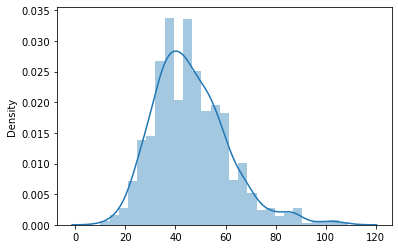

In [27]:
sns.distplot(lengths)

In [28]:
from rxitect import generate_chem_space

In [37]:
cspace = generate_chem_space.generate_chem_space(smi=decoded_samples[0], fp_type="ECFP4", num_random_samples=200, num_mutation_ls=[1, 2, 3])

Converting SELFIES back to SMILES: 100%|██████████| 200/200 [00:00<00:00, 4347.83it/s]


In [41]:
indices_thresh_4 = [i for i,x in enumerate(cspace[1]) if x > 0.4 and x < 0.6]
mols_4 = [Chem.MolFromSmiles(cspace[0][idx]) for idx in indices_thresh_4]

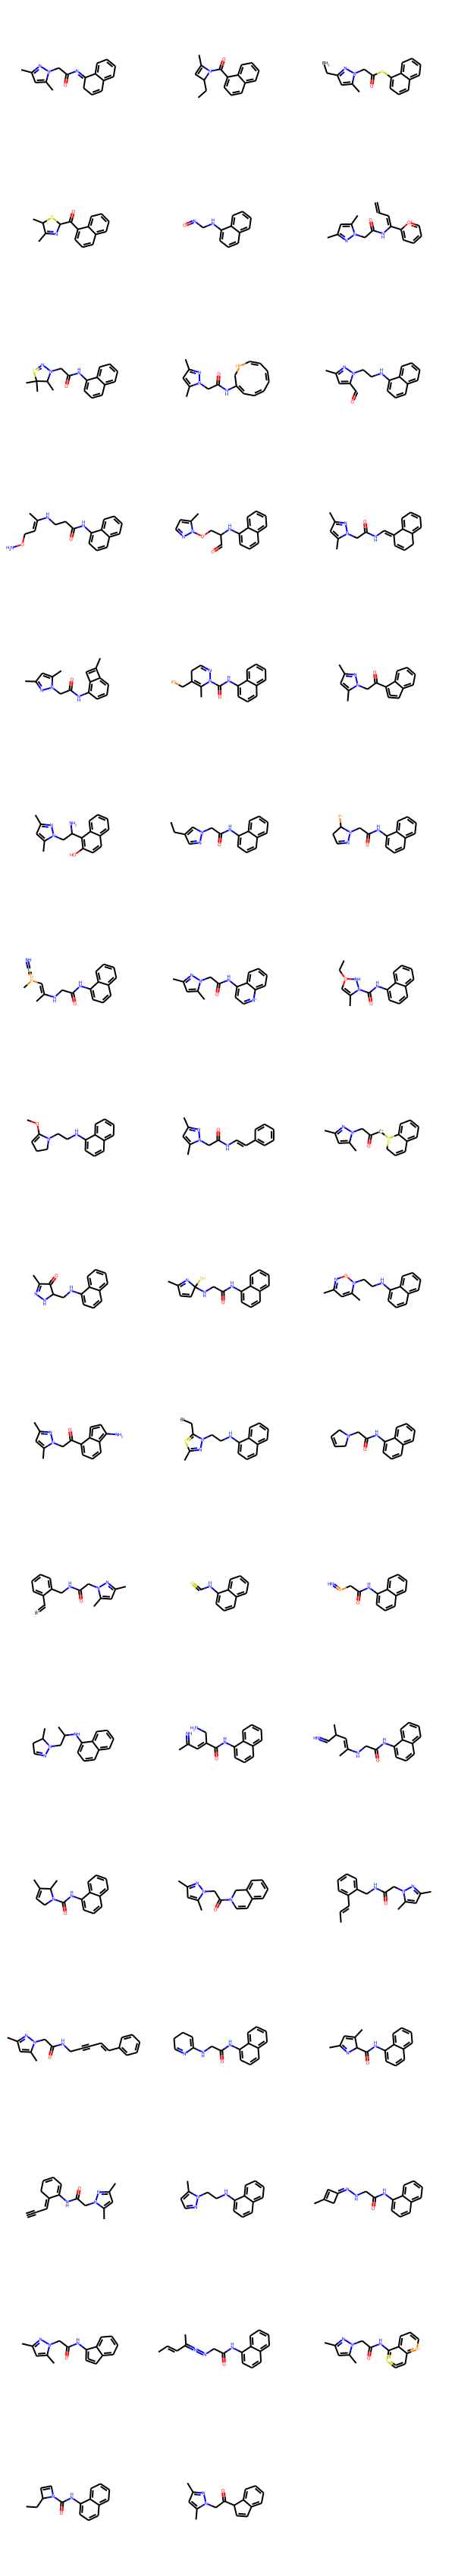

In [47]:
Draw.MolsToGridImage(mols_4[:50])